# Tutorial: Create a improvised RAG Piepline with Embedders using Haystack


## Installation


In [1]:
%%bash

pip install haystack-ai

You should consider upgrading via the '/Users/apple/Documents/haystack-book/venv/bin/python3 -m pip install --upgrade pip' command.


## Import necessary libraries


In [2]:
import os
import requests
from getpass import getpass
import textwrap

from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy

from haystack.components.embedders import OpenAITextEmbedder, OpenAIDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

from haystack import Pipeline

/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gathering data


In [3]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
document_store_with_embedded_data = InMemoryDocumentStore(
    embedding_similarity_function="cosine"
)

baseURL = "https://www.themealdb.com/api/json/v1/1/search.php?f="
alphabet = input("Enter your favourite alphabet: ")

# To handle user input
if len(alphabet) > 0:
    alphabet = alphabet[0]

data = requests.get(url=baseURL + alphabet)
data = data.json()

## Creating Documents


In [4]:
documents = []

for i in range(len(data["meals"])):
    title = data["meals"][i]["strMeal"]
    instructions = data["meals"][i]["strInstructions"]

    documents.append(
        Document(
            content="Title: " + title + "\nMaking Instructions: " + instructions,
            meta={
                "cuisine": data["meals"][i]["strCategory"]
                + " "
                + data["meals"][i]["strArea"],
                "url": data["meals"][i]["strYoutube"],
            },
        )
    )

## Create Indexing Pipeline


In [5]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")

In [6]:
def create_indexing_pipeline(document_store, metadata_fields_to_embed=None):
    indexing_pipeline = Pipeline()
    indexing_pipeline.add_component(
        "embedder",
        OpenAIDocumentEmbedder(meta_fields_to_embed=metadata_fields_to_embed),
    )
    indexing_pipeline.add_component(
        "writer",
        DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE),
    )

    indexing_pipeline.connect("embedder", "writer")

    return indexing_pipeline

In [7]:
indexing_pipeline = create_indexing_pipeline(document_store=document_store)
indexing_with_metadata_pipeline = create_indexing_pipeline(
    document_store=document_store, metadata_fields_to_embed=["cuisine"]
)

In [8]:
indexing_pipeline.run({"embedder": {"documents": documents}})
indexing_with_metadata_pipeline.run({"embedder": {"documents": documents}})

Calculating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 4540, 'total_tokens': 4540}}},
 'writer': {'documents_written': 17}}

## Query Pipeline


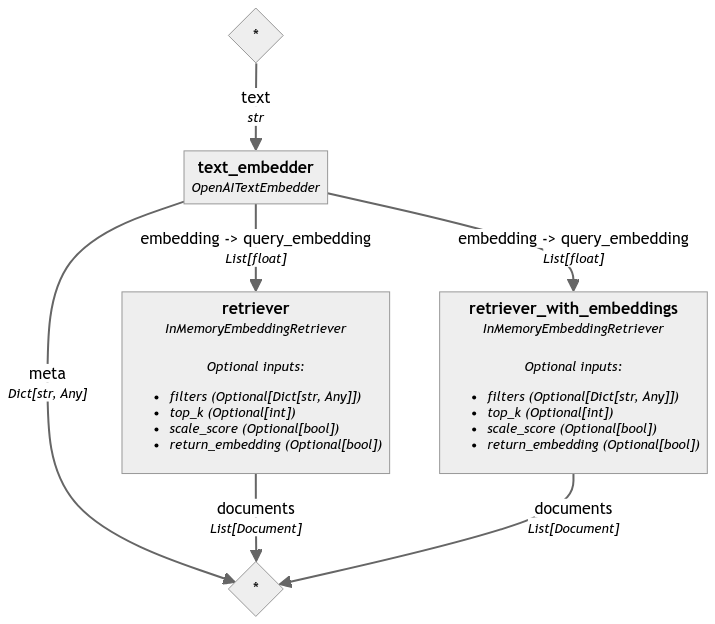

In [9]:
query_retrieval_pipeline = Pipeline()
query_retrieval_pipeline.add_component("text_embedder", OpenAITextEmbedder())
query_retrieval_pipeline.add_component(
    "retriever",
    InMemoryEmbeddingRetriever(
        document_store=document_store, scale_score=False, top_k=3
    ),
)
query_retrieval_pipeline.add_component(
    "retriever_with_embeddings",
    InMemoryEmbeddingRetriever(
        document_store=document_store_with_embedded_data, scale_score=False, top_k=3
    ),
)
query_retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
query_retrieval_pipeline.connect(
    "text_embedder.embedding", "retriever_with_embeddings.query_embedding"
)

## Execute Query Pipeline


In [10]:
query = input("Enter your query here: ")

In [11]:
result = query_retrieval_pipeline.run({"text_embedder": {"text": query}})

print("Retriever Results:\n")
for doc in result["retriever"]["documents"]:
    print(doc)
    print()

print()

print("Retriever with Embeddings Results:\n")
for doc in result["retriever_with_embeddings"]["documents"]:
    print(doc)
    print()

No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


Retriever Results:

Document(id=6cf43b3e9eec6f53cb38a75c582219de50d4c6e3484440efcd0ec7259193e533, content: 'Title: Mince Pies
Making Instructions: To make the pastry, rub 225g cold, diced butter into 350g pla...', meta: {'cuisine': 'Dessert British', 'url': 'https://www.youtube.com/watch?v=PnXft7lQNJE'}, score: 0.7583350576662986)

Document(id=2f81a11d47aed74d82390dde733924cac097228f2eb63e7bf4d600254fe2fd7f, content: 'Title: Madeira Cake
Making Instructions: Pre-heat the oven to 180C/350F/Gas 4. Grease an 18cm/7in ro...', meta: {'cuisine': 'Dessert British', 'url': 'https://www.youtube.com/watch?v=-YDh4WEmK_E'}, score: 0.7542023019265307)

Document(id=071d84eb71811350a8a6e4e35f7312395e20a189ebfbffb82b605f3882c76fd7, content: 'Title: Mushroom soup with buckwheat
Making Instructions: Chop the onion and garlic, slice the mushro...', meta: {'cuisine': 'Side Croatian', 'url': 'https://www.youtube.com/watch?v=M1ok7mG9-Qc'}, score: 0.7472977222442166)


Retriever with Embeddings Results:

